# Multiple Comparisons

## Import libraries

In [1]:
#!pip install scipy

In [2]:
#!pip install statsmodels

In [3]:
#!pip install scipy statsmodels matplotlib seaborn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import tt_ind_solve_power

In [5]:
from clickhouse_driver import Client


user_name = 'user_name'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Enter the average ARPU per user for the entire dataset in the field below with one decimal place. Use a period to separate the integer and fractional parts.**

At first let's check columns names of the data we have in our database. 

In [6]:
query = '''
DESCRIBE TABLE live_adverts
'''

In [7]:
result = client.execute(query)
result

[('execution_date', 'Date32', '', '', '', 'DoubleDelta', ''),
 ('advert_id', 'UInt64', '', '', '', 'T64', ''),
 ('created_at', 'DateTime', '', '', '', 'DoubleDelta', ''),
 ('price', 'UInt64', '', '', '', 'Gorilla', ''),
 ('region', 'LowCardinality(String)', '', '', '', '', ''),
 ('user_id', 'UInt32', '', '', '', 'T64', ''),
 ('platform', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_brand', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_model', 'LowCardinality(String)', '', '', '', '', ''),
 ('passport_id', 'UInt32', '', '', '', 'T64', ''),
 ('year', 'LowCardinality(String)', '', '', '', '', ''),
 ('userType', 'UInt8', '', '', '', 'T64', '')]

In [8]:
query = '''
DESCRIBE TABLE user_transactions
'''

In [9]:
result = client.execute(query)
result

[('payment_date', 'Date', '', '', '', '', ''),
 ('id', 'Int32', '', '', '', '', ''),
 ('type', 'String', '', '', '', '', ''),
 ('sign', 'Int32', '', '', '', '', ''),
 ('amount', 'Int32', '', '', '', '', ''),
 ('tstamp', 'DateTime', '', '', '', '', ''),
 ('advert_id', 'Int32', '', '', '', '', ''),
 ('passport_id', 'Int32', '', '', '', '', ''),
 ('balance_consumption', 'Int32', '', '', '', '', '')]

Now when we know the structure of the tables we can join the data to get a dataframe we need to solve the task. 

In [10]:
query = '''
SELECT
  CAST(la.passport_id AS String) AS passport_id,
  SUM(CASE WHEN ut.sign = -1 AND ut.amount < 0 THEN ut.balance_consumption END) AS money
FROM
  live_adverts la
LEFT JOIN
  user_transactions ut
    ON CAST(ut.advert_id AS String) = CAST(la.advert_id AS String)
      AND la.execution_date = ut.payment_date
        AND la.passport_id = ut.passport_id
WHERE
  la.execution_date BETWEEN '2022-01-01' AND '2022-02-28'
GROUP BY
  CAST(la.passport_id AS String)
'''

In [11]:
result = client.execute(query)

In [12]:
df = pd.DataFrame(result, columns=['passport_id', 'money'])

In [13]:
df.sample(5)

,passport_id,money
347479,136440479,NaN
33705,131946239,785.0
48320,133631125,1010.0
332777,138780630,NaN
379561,124626295,790.0


Let's fill the zero-spending clients with 0 instead of NaNs. 

In [14]:
df.fillna(0, inplace=True)

In [15]:
df.shape[0]

398500

In [16]:
df.passport_id.nunique()

398500

In [17]:
df.sample(5)

,passport_id,money
192508,138381354,0.0
199891,136525029,0.0
270091,136976231,175.0
222567,133066051,0.0
258114,141085777,1565.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398500 entries, 0 to 398499
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   passport_id  398500 non-null  object 
 1   money        398500 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.1+ MB


Loading experiment groups assignment data. 

In [19]:
groups_df = pd.read_csv('user_groups.csv', dtype={'passport_id': 'string'})

In [20]:
groups_df.passport_id.nunique()

398500

In [21]:
groups_df.sample(5)

,Unnamed: 0,passport_id,group
259315,259315,138062737,C
294746,294746,140506615,B
322078,322078,141572321,B
228895,228895,136761607,A
343736,343736,142343986,D


In [22]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398500 entries, 0 to 398499
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   398500 non-null  int64 
 1   passport_id  398500 non-null  string
 2   group        398500 non-null  object
dtypes: int64(1), object(1), string(1)
memory usage: 9.1+ MB


Merging clients spending data with experiment groups assignment data. 

In [23]:
data_df = pd.merge(df, groups_df[['passport_id', 'group']], how='inner', on='passport_id')

In [24]:
data_df

,passport_id,money,group
0,135655985,510.0,C
1,141737421,0.0,C
2,131999151,1650.0,A
3,134776715,175.0,A
4,129001315,0.0,D
...,...,...,...
398495,143024622,3971.0,D
398496,126984117,0.0,B
398497,138809936,330.0,D
398498,137173421,430.0,D


In [25]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398500 entries, 0 to 398499
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   passport_id  398500 non-null  object 
 1   money        398500 non-null  float64
 2   group        398500 non-null  object 
dtypes: float64(1), object(2)
memory usage: 12.2+ MB


Getting an answer to our question.

In [26]:
print(f'ARPU: {round(data_df.money.mean(), 1)}')

ARPU: 564.4


### Task 2.  

**Find ARPU in different groups.** 

In [27]:
data_df.groupby('group', as_index=False) \
    .agg({'money': 'mean'}).sort_values('money')

,group,money
1,B,527.843047
2,C,554.053060
3,D,587.104361
0,A,588.716362


### Task 3. 

**Check p-value using t-test for A-B, A-C, A-D, B-C, B-D, C-D.**

In [28]:
grp_a = data_df[data_df['group'] == 'A'].money
grp_b = data_df[data_df['group'] == 'B'].money
grp_c = data_df[data_df['group'] == 'C'].money
grp_d = data_df[data_df['group'] == 'D'].money

In [29]:
ttest_ind(grp_a, grp_b) 

Ttest_indResult(statistic=2.6233110388178775, pvalue=0.00870863765196825)

In [30]:
ttest_ind(grp_a, grp_c) 

Ttest_indResult(statistic=1.451475334743403, pvalue=0.14664911871458192)

In [31]:
ttest_ind(grp_a, grp_d) 

Ttest_indResult(statistic=0.05705982788476699, pvalue=0.954497594329015)

In [32]:
ttest_ind(grp_b, grp_c) 

Ttest_indResult(statistic=-1.6159436372726919, pvalue=0.10610807884643546)

In [33]:
ttest_ind(grp_b, grp_d) 

Ttest_indResult(statistic=-2.68276849006051, pvalue=0.007302154505735005)

In [34]:
ttest_ind(grp_c, grp_d) 

Ttest_indResult(statistic=-1.4493888066170024, pvalue=0.14723060414169875)

### Task 4. 

**Apply Sidak multiple comparison correction.**

In [35]:
pvals_lst = [
    ttest_ind(grp_a, grp_b).pvalue,
    ttest_ind(grp_a, grp_c).pvalue,
    ttest_ind(grp_a, grp_d).pvalue,
    ttest_ind(grp_b, grp_c).pvalue,
    ttest_ind(grp_b, grp_d).pvalue,
    ttest_ind(grp_c, grp_d).pvalue
    ]

In [36]:
ans = multipletests(pvals=pvals_lst,
              alpha=0.05,
              method='sidak')

print(f'Sidak corrected alpha: {ans[2]}')

Sidak corrected alpha: 0.008512444610847103


### Task 5. 

**What will be the new Holm-Bonferroni corrected alphas?**

In [37]:
alpha = 0.05
sorted_p_vals = sorted(pvals_lst)

n = len(sorted_p_vals)
rank = range(1, n + 1)
alphas_hb = [(alpha / (n - r + 1)) for r in rank]

alphas_hb

[0.008333333333333333, 0.01, 0.0125, 0.016666666666666666, 0.025, 0.05]

### Task 6. 

**Calculate the sample size through simulation with Holm-Bonferroni correction (to FWER 0.05) such that the power of finding all effects of 20% relative percentages in pairs A-B, A-C, A-D is guaranteed at the level of 0.8. Use group A as the base for the simulation.
The number of simulations per sample size is 200.
The increment step of the sample is 1000.
Use np.random.seed(1) before the first initialization.**

In [38]:
alpha = 0.05
def find_multi_tt_sample_size(hist_data, n_sim, sample_size_start, rel_effect, sample_size_step, power_set, plot = True, method = 'bonferroni'):
    '''
    hist_data - the metric from historical data that we use in the test.
    n_sim - the number of simulation iterations for each sample size.
    sample_size_start - the starting value of the sample size.
    rel_effect - the relative effect, MDE, that we want to check.
    sample_size_step - the increment step of the sample size.
    power_set - the power that we want to achieve.
    plot - is a boolean value that indicates whether we want to plot the graph.
    method - the multiple comparison correction method.
        - `bonferroni` : one-step correction
        - `sidak` : one-step correction
        - `holm-sidak` : step down method using Sidak adjustments
        - `holm` : step-down method using Bonferroni adjustments
        - `simes-hochberg` : step-up method  (independent)
        - `hommel` : closed method based on Simes tests (non-negative)
        - `fdr_bh` : Benjamini/Hochberg  (non-negative)
        - `fdr_by` : Benjamini/Yekutieli (negative)
        - `fdr_tsbh` : two stage fdr correction (non-negative)
        - `fdr_tsbky` : two stage fdr correction (non-negative)
    '''
 
    sample_size_list = []
    power_value_list = []
    power_value_corrected_list = []
 
    while True:
        p_value_list = []
        for i in range(n_sim):
            group_a = np.random.choice(hist_data, size = sample_size_start)
            group_b = np.random.choice(hist_data*(1+rel_effect), size = sample_size_start)
            group_c = np.random.choice(hist_data*(1+rel_effect), size = sample_size_start)
            group_d = np.random.choice(hist_data*(1+rel_effect), size = sample_size_start)
            ab_t_stat, ab_p_value = ttest_ind(group_a, group_b)
            ac_t_stat, ac_p_value = ttest_ind(group_a, group_c)
            ad_t_stat, ad_p_value = ttest_ind(group_a, group_d)
            p_value_list.append((ab_p_value, ac_p_value, ad_p_value))
 
        tp = np.logical_and.reduce([np.array(p_value_list)[:, 0] < alpha, np.array(p_value_list)[:, 1] < alpha, np.array(p_value_list)[:, 2] < alpha])
 
        # coorecting p-value
        hypothesys = []
        for i in range(len(p_value_list)):
            hypothesys.append(multipletests(p_value_list[i], alpha = 0.05, method = method)[0])
        tp_corrected =  np.logical_and.reduce([np.array(hypothesys)[:,0], np.array(hypothesys)[:,1], np.array(hypothesys)[:,2]])
 
        power_value = tp.mean()
        power_value_corrected = tp_corrected.mean()
        power_value_list.append(power_value)
        power_value_corrected_list.append(power_value_corrected)
        sample_size_list.append(sample_size_start)
        #print(i, sample_size_start, power_value)
        if power_value_corrected > power_set + 0.05:
            break
        else:
            sample_size_start += sample_size_step
 
    # calculating sample size
    non_corrected_power = power_value_list[np.argmax(np.array(power_value_list) >= 0.8)]
    corrected_power = power_value_corrected_list[np.argmax(np.array(power_value_corrected_list) >= 0.8)]
    non_corrected_sample_size = sample_size_list[np.argmax(np.array(power_value_list) >= 0.8)]
    corrected_sample_size = sample_size_list[np.argmax(np.array(power_value_corrected_list) >= 0.8)]
 
    # plotting results
    if plot: 
        plt.figure(figsize = (16, 8))
        sns.lineplot(x= sample_size_list, y = power_value_list, label = 'Non corrected power')
        sns.lineplot(x= sample_size_list, y = power_value_corrected_list, label = 'Corrected power')
        plt.axhline(y = 0.8, linestyle  = '--', color = 'red')
        plt.axvline(x = non_corrected_sample_size, linestyle  = '--', color = 'red')
        plt.axvline(x = corrected_sample_size, linestyle  = '--', color = 'blue')
 
        plt.text(x = round(non_corrected_sample_size*0.98),
                 y = np.quantile(power_value_list, 0.3),
                 s = 'Sample size without correction ~ {}'.format(non_corrected_sample_size),
                rotation = 'vertical',
                color = 'red')
        plt.text(x = round(corrected_sample_size*0.98),
                 y = np.quantile(power_value_list, 0.3),
                 s = 'Sample size with multiple testing correction ~ {}'.format(corrected_sample_size),
                rotation = 'vertical',
                color = 'blue')
 
    return_object = {'non_corrected sample_size': non_corrected_sample_size,
                     'corrected sample size': corrected_sample_size,
                    'non corrected power':non_corrected_power,
                    'corrected power':corrected_power }
 
    return(return_object)

Len of primary data = 99285
Mean =  588.7163619882158 Std =  6493.196516441093
Effect size =  0.018133329570345115
T-test without correction sample size = 47741
Sample size after multiple tests correction = 69000


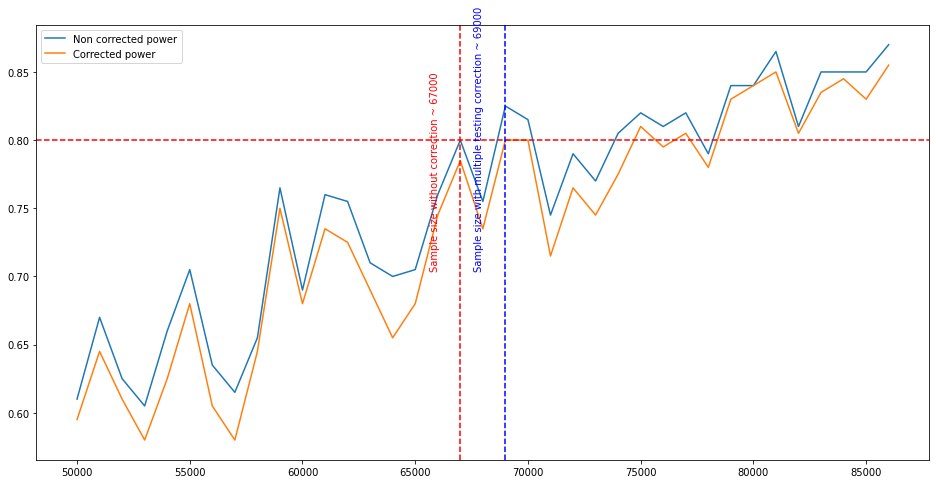

In [39]:
# our data
values_A = data_df[data_df['group'] == 'A'].sort_values('passport_id').money

# let's find the starting point (sample size for a simple A/B test)
print('Len of primary data =', len(values_A))
mean = values_A.mean()
std = values_A.std()
print('Mean = ', mean, 'Std = ', std)
rel_effect = 0.2
effect_size = mean*rel_effect / std
print('Effect size = ', effect_size)
sample_size = round(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.8, nobs1=None, alternative = 'two-sided'))#
print('T-test without correction sample size =', sample_size)
 
# running our function to determine sample size after correction
np.random.seed(1)
object = find_multi_tt_sample_size(hist_data=values_A,
                                   n_sim=200,
                                   sample_size_start=int(round(sample_size, -4)),
                                   rel_effect=0.2,
                                   sample_size_step=1000, 
                                   power_set=0.8,
                                   plot = True,
                                   method = 'holm')
 
print('Sample size after multiple tests correction =', object['corrected sample size'])